In [ ]:
from plotly.offline import init_notebook_mode, iplot_mpl, download_plotlyjs, plot, iplot
import plotly_express as px
import plotly.figure_factory as ff
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
import pandas_profiling
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score
from sklearn.metrics import precision_score, roc_auc_score, recall_score, roc_curve, precision_recall_curve
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import graphviz
from sklearn import tree
from sklearn.tree.export import export_text
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
import shap
from sklearn.feature_extraction import DictVectorizer
from yellowbrick.classifier import confusion_matrix, classification_report, ROCAUC, DiscriminationThreshold
from yellowbrick.target import ClassBalance, FeatureCorrelation
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.model_selection import CVScores, RFECV, LearningCurve,  ValidationCurve

from pdpbox import pdp, info_plots
from pdpbox.pdp import pdp_interact, pdp_interact_plot

from yellowbrick.features import RadViz, PCA, pca_decomposition
import lime
import lime.lime_tabular
plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'svg'
# Need to load JS vis in the notebook
shap.initjs() 

# <a id='#1'>Predicting credit card churn with tree based models</a>


In this project we have built tree-based models capable of predicting the credit cards churn. With the insights obtained, the bussiness can carry out proactive policies capable of providing better services and modifying customer decisions.

The data consists of 10,000 clients who mention their age, salary, marital status, credit card limit, credit card category, etc.
Thus, the 18 discrete and numerical attributes will help us to predict the "churn" of credit card users. The data has little need for pre-processing.

We only have 16.07% of customers who have abandoned credit card services. Therefore, we have an unbalanced data set. Although decision-tree algorithms are effective for the classification of balanced databases, in unbalanced datasets they can generate a bias. When the data is dominated by examples of one class, the criteria used to select a division point it will be considered optimal, when in fact, many examples of the minority class are ignored. This problem can be overcome by modifying the criteria used in the algorithm to evaluate the split points to take into account the importance of each class.


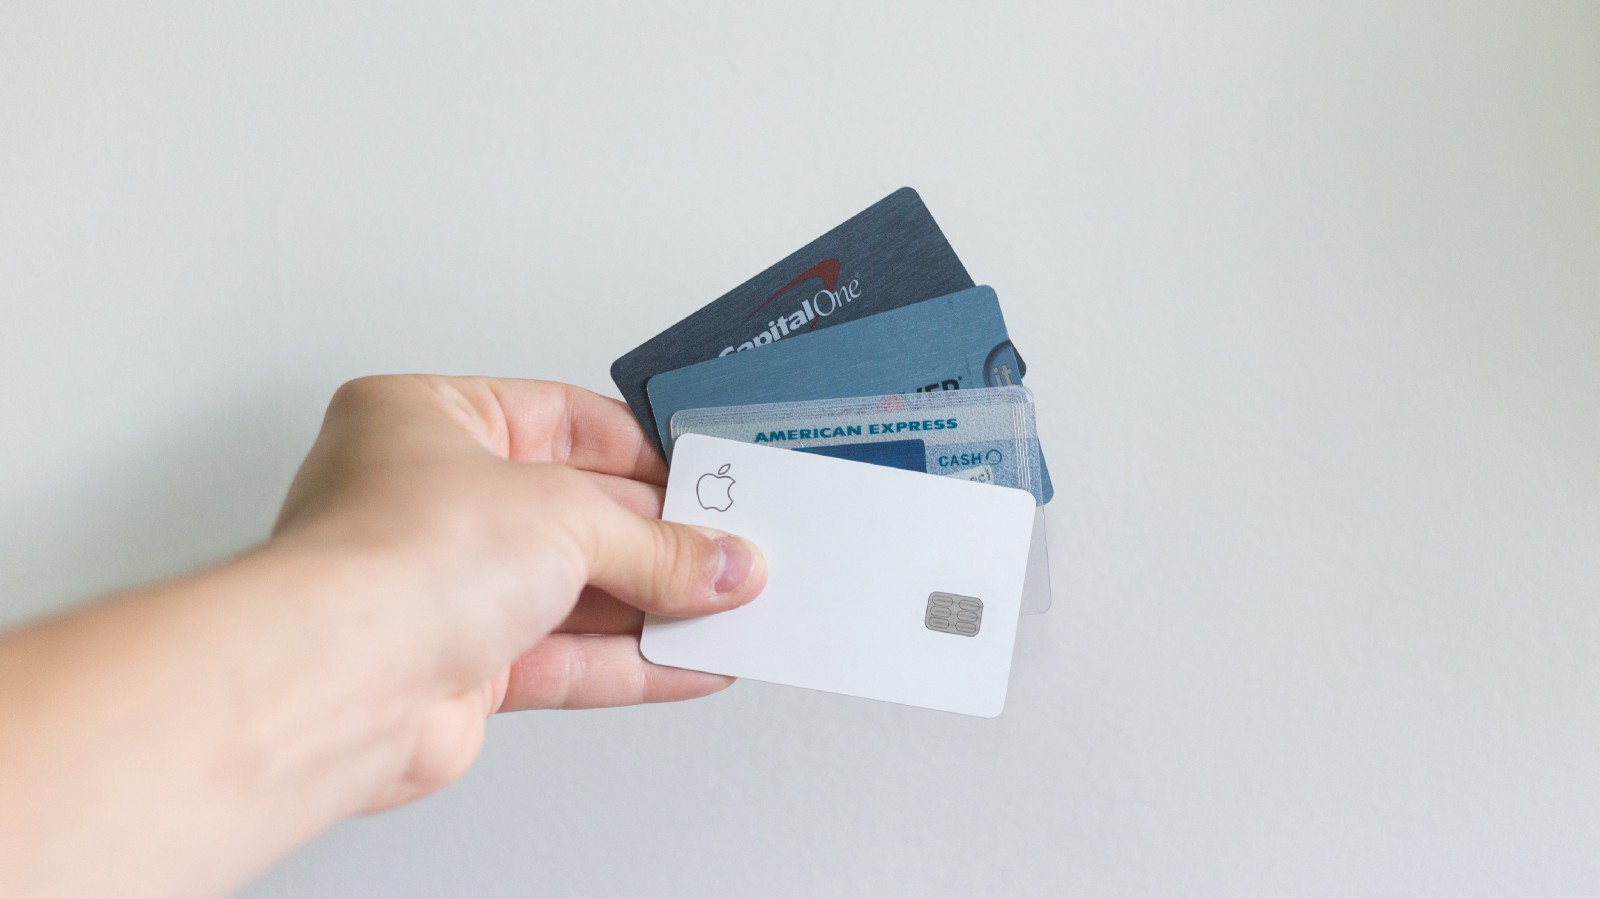

# <a id='#1'>1. DataSet preparation</a>

In [ ]:
data=pd.read_csv("../input/credit-card-customers/BankChurners.csv")

df=data.copy()

#the last two columns are noise
df=df.iloc[:,1:-2]

df.info()

We have no missing values.

### <a id='#1'>1.1 Pandas Profiling Report</a>

In [ ]:
pandas_profiling.ProfileReport(df)

In [ ]:
#Avg_Open_to_Buy is highly correlated with Credit_Limit, we can delete it  
df.drop(['Avg_Open_To_Buy'],axis=1,inplace=True)

# <a id='#1'>2. Exploratory data analysis </a>

In [ ]:
#We create the features matrix
X =df.iloc[:,1:]

#Target DataSet
y=df['Attrition_Flag']

#we replace the target vector with binary values
y=y.replace({'Existing Customer': 0,"Attrited Customer": 1})

###  <a id='#1'>2.1 Target </a>

In [ ]:
df[['Attrition_Flag']].head(3)

In [ ]:
fig = px.pie(df, 'Attrition_Flag', title='Pie Chart Target distribution', 
             color_discrete_sequence=px.colors.qualitative.Safe).update_traces(hoverinfo='label+value', 
  textinfo='percent', textfont_size=16,
).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')
fig.show()

The target we want to predict is the variable Attrition Falg. We observed that of the 10,000 observations, 16.1% were attried / churned.

### <a id='#1'> 2.2 Discrete Features distributions by average churn </a>

We examine the distribution by the mean of churn for each value of our discrete variables. These figures give us the count and the mean churn for each discrete variable value.

In [ ]:
d=df[['Gender','Education_Level','Marital_Status','Card_Category','Income_Category']]
d['churn']=y
d.head(3)

In [ ]:
#We transform the discrete features in dummy variables
d=pd.get_dummies(d)

#We drop the duplicated dummy variable gender
d.drop(['Gender_F'],axis=1,inplace=True)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=d, feature='Gender_M', feature_name='Gender', target='churn',figsize=(11, 7))
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

The data have a similar number of men and women. Women have almost 3 points more average churn than men.

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=d, feature=['Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown'], feature_name='Education', 
    target='churn',figsize=(11, 7)
)
_ = axes['bar_ax'].set_xticklabels(['College','Doctorate','Graduate','High School','Post-Graduate','Uneducated','Unknown'])

We observe that PhD and Postgraduate students have a higher percentage of churn.

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=d, feature=['Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',], feature_name='Marital_Status', 
    target='churn',figsize=(11, 7)
)
_ = axes['bar_ax'].set_xticklabels(['Divorced','Married','Single','Unknown'])

Married people are somewhat less prone to churn.

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=d, feature=['Card_Category_Blue',
       'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver',], feature_name='Card-Category', 
    target='churn',figsize=(11, 7)
)
_ = axes['bar_ax'].set_xticklabels(['Category_Blue','Category_Gold','Category_Platinum','Category_Silver'])

We observe that the platinum card users have the highest average churn and the silver ones the least, but there are only 20 platinum observations, so it may be statistical noise. The vast majority of observations have the Blue card.

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=d, feature=['Income_Category_$120K +', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Income_Category_Unknown'], feature_name='Income_Category', 
    target='churn',figsize=(11, 7)
)
_ = axes['bar_ax'].set_xticklabels(['$120K','$40K - $60K','$60K - $80K','$80K - $120K',
                                    'Less than $40K','Unknown'])

We observe that the observations with incomes of less than 40K and those of more than 120K have the highest average churn.

### <a id='#1'> 2.3 Distributions of numerical attributes by churn </a>

In this figure we can visualize in box-charts all the distributions of all the numeric variables by the classes of the target variable (no churn: 0, churn: 1).

In [ ]:
ec=df[df['Attrition_Flag']=='Existing Customer']
ac=df[df['Attrition_Flag']=='Attrited Customer']

fig = make_subplots(rows=7, cols=2, subplot_titles=("Customer_Age","Dependent_count",
 "Months_on_book","Total_Relationship_Count","Months_Inactive_12_mon",
"Contacts_Count_12_mon","Credit_Limit","Total_Revolving_Bal",
 "Total_Amt_Chng_Q4_Q1_1","Total_Trans_Amt","Total_Trans_Ct",
"Total_Ct_Chng_Q4_Q1","Avg_Utilization_Ratio"))

class0="0"
class1="1"

Customer_Age_0 = go.Box(x=ec.Customer_Age,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Customer_Age_1 = go.Box(x=ac.Customer_Age,name=class1,marker_color='rgba(255, 144, 14, 0.5)')

Dependent_count_0 = go.Box(x=ec.Dependent_count,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Dependent_count_1 = go.Box(x=ac.Dependent_count,name=class1,marker_color='rgba(255, 144, 14, 0.5)')

Months_on_book_0 = go.Box(x=ec.Months_on_book,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Months_on_book_1 = go.Box(x=ac.Months_on_book,name=class1,marker_color='rgba(255, 144, 14, 0.5)')

Total_Relationship_Count_0 = go.Box(x=ec.Total_Relationship_Count,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Total_Relationship_Count_1 = go.Box(x=ac.Total_Relationship_Count,name=class1,marker_color='rgba(255, 144, 14, 0.5)')


Months_Inactive_12_mon_0 = go.Box(x=ec.Months_Inactive_12_mon,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Months_Inactive_12_mon_1 = go.Box(x=ac.Months_Inactive_12_mon,name=class1,marker_color='rgba(255, 144, 14, 0.5)')


Contacts_Count_12_mon_0 = go.Box(x=ec.Contacts_Count_12_mon,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Contacts_Count_12_mon_1 = go.Box(x=ac.Contacts_Count_12_mon,name=class1,marker_color='rgba(255, 144, 14, 0.5)')


Credit_Limit_0 = go.Box(x=ec.Credit_Limit,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Credit_Limit_1 = go.Box(x=ac.Credit_Limit,name=class1,marker_color='rgba(255, 144, 14, 0.5)')

Total_Revolving_Bal_0 = go.Box(x=ec.Total_Revolving_Bal,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Total_Revolving_Bal_1 = go.Box(x=ac.Total_Revolving_Bal,name=class1,marker_color='rgba(255, 144, 14, 0.5)')

Total_Amt_Chng_Q4_Q1_0 = go.Box(x=ec.Total_Amt_Chng_Q4_Q1,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Total_Amt_Chng_Q4_Q1_1 = go.Box(x=ac.Total_Amt_Chng_Q4_Q1,name=class1,marker_color='rgba(255, 144, 14, 0.5)')

Total_Trans_Amt_0 = go.Box(x=ec.Total_Trans_Amt,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Total_Trans_Amt_1 = go.Box(x=ac.Total_Trans_Amt,name=class1,marker_color='rgba(255, 144, 14, 0.5)')


Total_Trans_Ct_0 = go.Box(x=ec.Total_Trans_Ct,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Total_Trans_Ct_1 = go.Box(x=ac.Total_Trans_Ct,name=class1,marker_color='rgba(255, 144, 14, 0.5)')

Total_Ct_Chng_Q4_Q1_0 = go.Box(x=ec.Total_Ct_Chng_Q4_Q1,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Total_Ct_Chng_Q4_Q1_1 = go.Box(x=ac.Total_Ct_Chng_Q4_Q1,name=class1,marker_color='rgba(255, 144, 14, 0.5)')

Avg_Utilization_Ratio_0 = go.Box(x=ec.Avg_Utilization_Ratio,name=class0,marker_color='rgba(93, 164, 214, 0.5)')
Avg_Utilization_Ratio_1 = go.Box(x=ac.Avg_Utilization_Ratio,name=class1,marker_color='rgba(255, 144, 14, 0.5)')


fig.append_trace(Customer_Age_0, 1, 1)
fig.append_trace(Customer_Age_1, 1, 1)

fig.append_trace(Dependent_count_0, 1, 2)
fig.append_trace(Dependent_count_1, 1, 2)

fig.append_trace(Months_on_book_0, 2, 1)
fig.append_trace(Months_on_book_1, 2, 1)

fig.append_trace(Total_Relationship_Count_0, 2, 2)
fig.append_trace(Total_Relationship_Count_1, 2, 2)

fig.append_trace(Months_Inactive_12_mon_0, 3, 1)
fig.append_trace(Months_Inactive_12_mon_1, 3, 1)

fig.append_trace(Contacts_Count_12_mon_0, 3, 2)
fig.append_trace(Contacts_Count_12_mon_1, 3, 2)

fig.append_trace(Credit_Limit_0, 4, 1)
fig.append_trace(Credit_Limit_1, 4, 1)

fig.append_trace(Total_Revolving_Bal_0, 4, 2)
fig.append_trace(Total_Revolving_Bal_1, 4, 2)


fig.append_trace(Total_Amt_Chng_Q4_Q1_0, 5, 1)
fig.append_trace(Total_Amt_Chng_Q4_Q1_1, 5, 1)


fig.append_trace(Total_Trans_Amt_0, 5, 2)
fig.append_trace(Total_Trans_Amt_1, 5, 2)

fig.append_trace(Total_Trans_Ct_0, 6, 1)
fig.append_trace(Total_Trans_Ct_1, 6, 1)

fig.append_trace(Total_Ct_Chng_Q4_Q1_0 , 6, 2)
fig.append_trace(Total_Ct_Chng_Q4_Q1_1, 6, 2)

fig.append_trace(Avg_Utilization_Ratio_0 , 7, 1)
fig.append_trace(Avg_Utilization_Ratio_1, 7, 1)


fig.update_layout(height=1500, width=700,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)', showlegend=False)

fig.update_layout(title_text="Numerical variables Box-plot distribution per class {no churn: 0 & churn: 1}")

fig.show()


We observe, for example, for the Total_Trans_Ct, the observations of class 0 have a distribution with high values (median of 71) in relation to the median of 43 for class 1.

### <a id='#1'> 2.4 Distributions of numerical features by average churn mean </a>
We perform the same analysis as with the discrete attributes, this time separating the values of the numerical variables into intervals. 1.

In [ ]:
n=X[['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']]
n['churn']=y

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Customer_Age', feature_name='Customer_Age', 
    target='churn',figsize=(11, 7)
)

We did not observe very significant differences with age. The youngest age groups are the ones with the least average churn.

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Dependent_count', feature_name='Dependent_count', 
    target='churn',figsize=(11, 7)
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Months_on_book', feature_name='Months_on_book', 
    target='churn',figsize=(11, 7)
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Total_Relationship_Count', feature_name='Total_Relationship_Count', 
    target='churn',figsize=(11, 7)
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Months_Inactive_12_mon', feature_name='Months_Inactive_12_mon', 
    target='churn',figsize=(11, 7)
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Contacts_Count_12_mon', feature_name='Contacts_Count_12_mon', 
    target='churn',figsize=(11, 7)
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Total_Revolving_Bal', feature_name='Total_Revolving_Bal', 
    target='churn',figsize=(11, 7)
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Total_Amt_Chng_Q4_Q1', feature_name='Total_Amt_Chng_Q4_Q1', 
    target='churn',figsize=(11, 7)
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Total_Trans_Amt',num_grid_points=8, feature_name='Total_Trans_Amt', 
    target='churn',figsize=(11, 7)
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Total_Trans_Ct', feature_name='Total_Trans_Ct', 
    target='churn',figsize=(11, 7)
)

We observe that from total_Trans_Ct > 54, the churn average goes down a lot, becoming almosty 0 from total_Trans_Ct > 90.

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=n, feature='Avg_Utilization_Ratio', feature_name='Avg_Utilization_Ratio', 
    target='churn',figsize=(11, 7)
)

In the interval [0,0.07) the average churn is 30%.

# <a id='#1'> 3. Feature engineering and feature matrix examination </a>

The creation of new variables from the data you have available can improve the predictive power of our algorithms. This is where the stage of data exploration of  and the knowledge domain become very important.

In [ ]:
X.head()

Using the variables Total_Trans_Amt and Total_Trans_Ct we can generate a variable that reproduces the average transaction made by user.

In [ ]:
X['Av_Trans']=X['Total_Trans_Amt']/X['Total_Trans_Ct']

In [ ]:
X['Av_Trans']

Using the variables Total_Trans_Amt and Credit_Limit we can generate a new variable that denotes the amount used by customer in relation to their credit limit.

In [ ]:
X['Amt_used_per_Limit']=X['Total_Trans_Amt']/X['Credit_Limit']

In [ ]:
X['Amt_used_per_Limit']

We observe how those clients with a high number of transactions do not usually churn the services. There is no churn observation with a Total Transaction Amount> 10584. (see box-plots distribution) We can generate a discrete variable that cuts these continuous data into two intervals (0, 10584] and (10584, 18485]

In [ ]:
X['Dis_Total_Trans_Amt']=pd.cut(X['Total_Trans_Amt'], [0,10584,18485], include_lowest=False)

In [ ]:
X['Dis_Total_Trans_Amt']

### <a id='#1'> 3.1 We transform discrete variables into dummy variables </a>

Scikit learn's Decision Tress algorithm cannot process discrete variables, so we have to convert discrete attributes to dummy variables.

In [ ]:
X.head()

In [ ]:
#We transform the discrete features into dummy variables 
X=pd.get_dummies(X)

#We drop the duplicated dummy variable gender
X.drop(['Gender_F'],axis=1,inplace=True)

In [ ]:
X.head()

We have 39 features. Many features may not be useful / important but we will use them all so as not to detract predictive power to our model.

### <a id='#1'>3.2 Mutual Info-classification </a>

This figure details the mutual information of each feature with the target. Mutual information measures the reduction of uncertainty for one variable given a known value of another. The mutual information between two random variables X and Y can be formally established as follows:

     I (X; Y) = H (X) - H (X | Y)

Where I (X; Y) is the mutual information for X and Y, H (X) is the entropy for X and H (X | Y) is the conditional entropy for X given Y.

Mutual information is a measure of dependency or "mutual dependency" between two random variables. As such, the measure is symmetric, which means that I (X, Y) = I (Y, X). It measures the average reduction in uncertainty about x that results from learning the value of y; or vice versa, the average amount of information that x conveys about y.

In [ ]:
# Instaniate the visualizer
visualizer = FeatureCorrelation(
    method='mutual_info-classification', feature_names=X.columns.tolist(), sort=True,
size=(2900, 3000))

visualizer.fit(X, y,)              # Fit the data to the visualizer
visualizer.show()                  # Finalize and render the figure

We observe that the variables with the highest score are Total_Trans_Amt and Total_Trans_Ct.

### <a id='#1'>3.3 PCA Projection matrix X </a>

The PCA Decomposition Viewer uses principal component analysis to decompose data so that each instance can be represented in a 2-d scatter plot. .

In [ ]:
visualizer = PCA(scale=True, proj_features=True,size=(3000, 2000),alpha=0.75)
visualizer.fit_transform(X, y)
visualizer.show()

We observe that in PCA the data are separated into two clusters. In the cluster with high PC1 values, all observations are without churn. Each feature of the set is projected to its direction of maximum variance. We see that Total_Trans_Ct, Total_rans_Amt and the dummy variable of Total_Trans_Amt are projected onto this cluster.

### <a id='#1'> 3.3 X Circumference Projection </a>

RadViz is a multivariate data visualization algorithm that plots each attribute uniformly around the circumference of a circle and then plots points inside the circle such that the point normalizes its values on the axes from the center to each arc. This mechanism allows as many dimensions as can easily fit in a circle, expanding the dimensionality of the display. It gives us an idea of the separability between classes.

In [ ]:
# Specify the target classes
classes = ["no churn", "churn"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes,size=(2400, 3000),alpha=0.2)

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Finalize and render the figure

#  <a id='#1'>4. Decision Trees for Imbalanced Classification </a>

### <a id='#1'> Decision Trees </a>

Decision trees are supervised learning algorithms that are used for both classification and regression tasks. We can use decision trees for data sets in which we have both continuous and discrete attributes. The main idea of decision-trees is to find the descriptive features that contain the most "information" about the target class that we want to predict and then divide the data set along the values of these features so that the values of the target characteristics for the sub_datasets are as pure as possible.


This process of finding the "most informative" feature is done until we reach a stopping criterion where we finally end up in so-called leaf nodes. The leaf nodes contain the predictions that we will make for the new query instances presented to our trained model. This becomes possible since the model has learned the underlying structure of the data and can therefore, given some assumptions, can make predictions about the target class value of the query instances.

A decision tree mainly contains a root node, interior nodes, and leaf nodes that are then connected by branches.

### <a id='#1'> Balanced Decision Trees </a>

In binary decision trees, if the frequency of class A is much higher than the frequency of class B, then class B will become the ruling class and its tree will lean towards the ruling class. To avoid this casuistry, we pass the parameter **class_weight = 'balanced'**, to perform an automatic adjustment according to the proportion of frequencies of each class and thus, each class will be treated with the same importance and the number of records of each class in the tree nodes will be the same.

As such, this modification of the decision tree algorithm is known as a class-weighted decision tree.

### <a id='#1'> 4.1 Stratified train test split </a>

We keep 20% of the observations as test set (out of sample data) to be able to predict with samples not used in training and to have an estimate of the errors. With the stratify = y method, we make sure that the two data sets have the same per-rate per class as the original data set.

In [ ]:
# Stratified Train_test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = random_state, stratify = y)

### <a id='#1'>4.2 Default class-balanced Decision Tree</a>

In [ ]:
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)

We can examine the text of the set of rules generated by the decision tree.

In [ ]:
tree_rules = export_text(model,show_weights=True, feature_names=list(X.columns))
print(tree_rules)

In [ ]:
# DOT data
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=list(X.columns),class_names=y.astype(str),
                                max_depth=2,proportion=False, filled=True,)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

Let's see how the tree represented in the figure makes predictions.

   - **Samples:** refers to how many instances the condition is met. For example, 3022 observations have a Total_Trans_Ct <= 57.5 and 5079 observations have a Total_Trans_Ct> 57.5.
   

   - **Value:** tells you how many training instances of each class this node applies to: for example, the lower left node Total_Ct_Chng_Q4_Q1 <= 0.866 applies to value = [173.363, 2183.91] class 0, class 1.
  
    
   - **Gini:** measures impurity. A node is "Pure" (gini = 0) if all the training instances it applies belong to the same class. for example, at left node of depth 8, Contacts_Count_12_mon <= 1.50, all instances belong to class 0, so the node is pure.
   
- | --- Total_Trans_Ct <= 57.50
- | | --- Total_Revolving_Bal <= 656.50
- | | | --- Total_Ct_Chng_Q4_Q1 <= 0.87
- | | | | --- Months_Inactive_12_mon <= 1.50
- | | | | | --- Contacts_Count_12_mon <= 1.50
- | | | | | | --- weights: [7.15, 0.00] class: 0


Starting at the root node (depth 0), this node asks if the total number of transactions is <= 57.5. If true, it moves down to the child node and asks another question, and so on.

**Example decision rule for predicting churn**

- | --- Total_Trans_Ct <= 57.50
- | | --- Total_Revolving_Bal <= 656.50
- | | | --- Total_Ct_Chng_Q4_Q1 <= 0.87
- | | | | --- Months_Inactive_12_mon <= 1.50
- | | | | | --- Contacts_Count_12_mon> 1.50
- | | | | | | --- Total_Ct_Chng_Q4_Q1 <= 0.49
- | | | | | | | --- Customer_Age> 30.50
- | | | | | | | | --- Total_Revolving_Bal <= 430.50
- | | | | | | | | | --- Education_Level_Doctorate <= 0.50
- | | | | | | | | | | --- Income_Category_ $ 40K - $ 60K <= 0.50
- | | | | | | | | | | | --- Total_Relationship_Count <= 3.50
- | | | | | | | | | | | | --- weights: [0.00, 40.44] class: 1


**When the observation meets all these criteria, upon reaching the. sheet Total_Relationship_Count <= 3.50, node; if yes, the tree predicts the person is likely to churn**

### <a id='#1'> 4.3 Evaluation with cross-validation </a>

The Cross-Validation function randomly divides the training set into K distinct subsets and train and evaluate the decision tree model k times, choosing a different subset for evaluation each time and training in the other k subset folds. The result is a matrix with the k evaluation metrics. We will divide the data set into 10 subsets (k = 10).

In [ ]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=2)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

In [ ]:
scores.mean()

As the results may vary due to the stochastic nature of the evaluation procedure, we run the Cross-validation multiple times and compute the mean of the result. We observe that the model has obtained a mean of 0.79 of the metric f1.

In [ ]:
visualizer = CVScores(model, cv=cv, scoring='f1', random_state=2, size=(5500, 1000))

visualizer.fit(X_train, y_train) # Fit the data to the visualizer

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 

visualizer.show() 
# Finalize and render the figure

Here we can examine the score for each of the cross-validation validations. (in 10 repetitions of 10 fold cross-validation).

### <a id='#1'> 4.4 Model Testing: Confusion Matrix and Classification Report </a>

We analyze the classificatory performance of our model by examining the confusion matrix and the recall and precision of the model. The confusion matrix gives us the false negatives (lower left value) and false positives (upper right value). Correctly classified values are on the main diagonal. (class 0 as 0 and class 1 as 1)

In [ ]:
# Instantiate the visualizer with the classification model
confusion_matrix(
    model,
    X_train, y_train, X_test, y_test,
    classes=['no churn', 'churn']
)
plt.show()

We observed that the model has relatively many more false negatives ("churn" clients who were not identified as such) than false positives (clients who did not leave the services but were identified as "churn".)

In [ ]:
# Instantiate the visualizer
visualizer = classification_report(model, X_train, y_train, X_test, y_test, 
                                   classes=['non_churn', 'churn'], support=True)

**PRECISION**

Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives. False positives are instances that the model incorrectly labels "churn" when they are actually negative. It expresses the proportion of the data points that our model says are relevant when in fact they were relevant.


**RECALL**

The recall is the number of true positives divided by the number of true positives plus the number of false negatives. True positives are data points classified as positive by the model that are actually positive (correct), and false negatives are data points that the model identifies as negative that are actually positive (incorrect). In the case of churn, the true positives are customers who left credit card services and are correctly identified, and the false negatives would be individuals labeled "no churn" by the model, but who actually left the services. It expresses the ability to find all relevant instances in a data set.

**F1-SCORE**

In some situations, we may want to maximize recall or precision at the expense of the other metric. In the case that we are trying to "churn" customers, we can accept a lower precision if we can obtain a higher recall (we want to find many customers who intend to abandon credit card services). However, in cases where we want to find an optimal combination of precision and recall, we can combine the two metrics using what is called an F1 score.

The F1 score is the harmonic mean of precision and recall taking into account both metrics. The harmonic mean is used instead of a simple average because it penalizes extreme values.

# <a id='#1'> 5. Hyperparameter tuning with GridSearch Cross-Validation </a>

Scikit-Learn's GridSearchCV method optimizes the algorithm using cross-validation by evaluating all possible combinations of hyperparameter values. Finds the best combination of hyperparameter values from the Decision Tree.

Hyperparameter tuning is the process of tuning the parameters present in the algorithm. Machine learning algorithms never learn these parameters. These are tuned so that we can get good performance per model. The goal of hyperparameter fitting is to find those parameters where the model performance is better and the error rate is lower.

In [ ]:
# define grid
parameters = {'min_samples_leaf' : range(1,10,1),'min_samples_split' : range(1,10,1),
              'max_depth': range(1,30,2),'criterion':['gini','entropy']}

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=2)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=-1, cv=cv, scoring='f1')

# execute the grid search
grid_result = grid.fit(X_train, y_train)

In [ ]:
viz = ValidationCurve(
    model, param_name="max_depth", param_range=range(1,10,1),
    logx=True, cv=cv, scoring="f1", n_jobs=8,size=(3700, 2000))

viz.fit(X, y)
viz.show()

This figure tells us  how effective an estimator is on the data that it has been trained on as well as how generalizable it is to new input to different hyperparameter ranges (max depth) on the training and test data. 

### <a id='#1'> 5.1 Confusion Matrix & Classification Report</a>

In [ ]:
# Instantiate the visualizer with the classification model
confusion_matrix(
    grid_result,
    X_train, y_train, X_test, y_test,
    classes=['non_churn', 'churn']
)
plt.show()

In [ ]:
# Instantiate the visualizer
visualizer = classification_report(grid_result, X_train, y_train, X_test, y_test, 
                                   classes=['non_churn', 'churn'], support=True)

With GridSearch CV the model has somewhat more solid results.

# <a id='#1'> 6. Random forest model </a>

Random Forests consist of many decision trees. To classify a new instance, each decision tree provides a classification for the input data; random forest collects all the rankings and chooses the most voted prediction as a result. In addition, a subset of features is randomly selected from the optional features to grow the tree at each node. Each tree is grown without pruning. Basically, the random forest allows a large number of weak or weakly correlated classifiers but forms a very strong joint classifier.

- We will generate the model with 1000 trees.

In [ ]:
model1 = RandomForestClassifier(random_state=0,n_estimators=1000,class_weight='balanced')

model1.fit(X_train, y_train)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=2)

# evaluate model
scores = cross_val_score(model1, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

scores.mean()

### <a id='#1'> 6.2 Model learning curve </a>

The learning curve of the model shows us the relationship between the F-1 score and the cross-validation tests of the model with an increasing number of training samples. This visualization is normally used to show two things:

     How much the model benefits from more data (eg, do we have "enough data" or will the estimator improve with new data.

     If the estimator is more sensitive to error due to variance versus error due to bias.

The increasing progression of the curve denotes that the model will benefit from more data to generalize better.

The curves are plotted with the mean scores; however, the variability during cross validation is shown with the shaded areas representing one standard deviation above and below the mean for all cross validations.

In [ ]:
# Create the learning curve visualizer
sizes = np.linspace(0.3, 1.0, 20)

# Instantiate the visualizer
visualizer = LearningCurve(
    model1, cv=cv, scoring='f1', train_sizes=sizes, n_jobs=-1,size=(3700, 2000))

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()                       # Finalize and render the figu

In [ ]:
# Instantiate the visualizer with the classification model
confusion_matrix(
    model1,
    X_train, y_train, X_test, y_test,
    classes=['non_churn', 'churn']
)
plt.show()

In [ ]:
# Instantiate the visualizer
visualizer = classification_report(model1, X_train, y_train, X_test, y_test, 
                                   classes=['non_churn', 'churn'], support=True)

The Random Forest gets a much higher f-1 score than previous models.

### <a id='#1'> 6.1 Model probabilities </a>

The predict_proba method of scikit learn allows us to obtain the probabilities that the observation is of a certain class.

In [ ]:
predicted_proba = model1.predict_proba(X_test)
predicted_proba 

## <a id='#1'> 7. Models Precision-Recall curve </a>

We can examine the Precision-Recall curve of the 3 computed models and analyze their predictive quality. A Recall-Precision curve is a graph of the precision (y-axis) and recall (x-axis) for different thresholds.

In [ ]:
#scores per model
y_score_ = model.predict_proba(X_test)[:,1]
y_score = grid_result.predict_proba(X_test)[:,1]
m1_y_score=model1.predict_proba(X_test)[:,1]

# Precision-recall curve
precision_, recall_, thresholds_ = precision_recall_curve(y_test, y_score_)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
m1_precision,m1_recall,m1_tresholds=precision_recall_curve(y_test, m1_y_score)

#Models Data
frame = { 'Precision': precision, 'Recall': recall} 
pc=pd.DataFrame(frame) 

frame_ = { 'Precision_': precision_, 'Recall_': recall_} 
pc_=pd.DataFrame(frame_) 

frame__ = { 'Precision': m1_precision, 'Recall': m1_recall} 
m1=pd.DataFrame(frame__) 


#figure
fig = go.Figure()
  
fig.add_trace(go.Scatter(x=pc.Recall,y=pc.Precision, fill='tozeroy',text='Grid Search CV model',
                         name='Grid-SearchCV DT')) # fill down to xaxis
fig.add_trace(go.Scatter(x=pc_.Recall_, y=pc_.Precision_, fill='tozeroy',text="Default decision tree model",
                         name="Default Balanced DT")) # fill to trace0 y

fig.add_trace(go.Scatter(x=m1.Recall, y=m1.Precision, fill='tonexty',text="Random Forest model",
                         name="Random Forest")) # fill to trace0 y


fig.update_layout(
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)', showlegend=True)

fig.update_layout(title_text="Precision-Recall curve",xaxis_title="Recall",
    yaxis_title="Precision",
    legend_title="MODELS",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

A high area under the curve represents both high recall and high precision, where high precision is related to a low false positive rate and high recovery is related to a low false negative rate. We observe how the Random Forest has much more predictive power than the two individual decision tree models.
 
**So how do we know if we have to sacrifice precision for recall or vice versa to find churn clients?**

This is where data mining meets specific knowledge of different contexts. If we calculate that the cost of letting clients escape with undetected churn (False negatives) is very high, we can choose a higher recall sacrificing precision, or at best we consider that finding 80% of clients with churn is good enough to business and we do not want unnecessary disruptions with customers while maintaining high precision.

# <a id='#1'>8. 90% Recall Predictor </a>

In the previous figure we observe that if we want a model capable of letting only 10% of the users escape with churn (Recall of 90%), we will have to settle for an accuracy of 83%. (Random Forest model) Accessing the probabilities that the model computes, we can execute the treshold (or decisional limit of probability) that we want to make predictions.

### <a id='#1'>8.1 Precision-Recall vs Threshold</a>

In [ ]:
tresholds=np.linspace(0,1,100).tolist()
pre=[]
rec=[]

for threshold in np.linspace(0,1,100):
    predicted = (predicted_proba [:,1] >= threshold).astype('int')
    
    rec.append(recall_score(y_test, predicted).tolist())
    pre.append(precision_score(y_test,predicted).tolist())
    
tr= pd.DataFrame({'tresholds': tresholds,'precision':pre,'recall':rec})
tr=tr.iloc[:-1,:]



#figure
fig = go.Figure()


fig.add_trace(go.Scatter(x=tr.tresholds, y=tr.precision, fill='tonexty',text="Precision",
                         name="Precision")) # fill to trace0 y


fig.add_trace(go.Scatter(x=tr.tresholds, y=tr.recall, fill='tozeroy',text="Recall",
                         name="Recall")) # fill to trace0 y

fig.update_layout(
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)', showlegend=True)

fig.update_layout(title_text="Precision-Recall vs Threshold",xaxis_title="Threshold",
    yaxis_title="Precision / Recall",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
                 )

fig.add_shape(type='line',
                x0=0.326,
                y0=0,
                x1=0.326,
                y1=1,
                line=dict(color='Red', dash="dot"),
                xref='x',
                yref='y')

fig.add_annotation(
        x=0.326,
        y=0.90,
        xref="x",
        yref="y",
        text="Recall 0.90",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#ffffff"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="coral",
        opacity=0.8
        )

fig.add_annotation(
        x=0.326,
        y=0,
        xref="x",
        yref="y",
        text="Probability Threshold 0.33",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#ffffff"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="violet",
        opacity=0.8
        )

fig.show()

As we can see, the higher the probability Threshold of the model, the lower the Recall. Similarly, increasing the Treshold increases the accuracy of the model. Thus, to build a high recall predictor we have to modify the standard predictor that has the treshold 0.5 to 0.326.

In [ ]:
# Instantiate the classification model and visualizer

visualizer = DiscriminationThreshold(model1,size=(3700, 2000)) 
visualizer.fit(X_train, y_train)        # Fit the data to the visualizer      # Final
visualizer.show()

The Yellobrick package offers us the same visualization with the f1 score included. The maximum f1 score is achieved with the 0.35 treshold.

We proceed to modify the threshold to achieve a model with a 90% recall.

In [ ]:
# y_pred = clf.predict(X_test)  # default threshold is 0.5
y_pred = (model1.predict_proba(X_test)[:,1] >= 0.3265306) # set threshold as 0.326

pred=pd.DataFrame({'y_pred':y_pred.tolist(),'y_test':y_test})
pred.y_pred=pred.y_pred.replace({False: 0,True: 1})

recall_score(pred.y_test, pred.y_pred)

In [ ]:
precision_score(pred.y_test, pred.y_pred)

With this threehold, the recall score is 0.9 and we managed to capture 90% of the customers with churn in the test Set data set, but, of course,  we sacrifice the precision we had with the threshold of 0.5, since we have a precision of 0.84.

# <a id='#1'> 9. Feature importance with Random Forest Classification: Information Gain </a>

One of the main advantages of decision tree models is their interpretability. Thus, we can study the importance of model features  by examining the relative importance of each feature to perform the prediction task. Performing this analysis can help us better understand the data in our model. This is measured  the importance of each feature in the algorithm training by examining the average amount of impurity that the nodes of the tree that that attribute manages to reduce. These data must be analyzed with caution, since algorithms with trees tend to overestimate the importance of attributes with high cardinality and highly correlated attributes cause distortions in the valuation.

In [ ]:
eli5.show_weights(model1, feature_names = X_test.columns.tolist())

# <a id='#1'> 10. Partial dependency plots & prediction distributions per target plots </a>

Partial dependency graphs show the dependency between the target class and a feature , removing the effects of all other features. These graphs can show if the relationship between the linear, monotonic target class, ... In short, they help us to better understand the dependencies between the attributes of our model and the target class. To compute these graphs, we predict the probability of the target class with new data, but changing the values of the variable before making a prediction. Thus, we first predict the churn probability for the different values that the attribute takes and then we plot how the probability of the target class changes for the different values that the attribute takes.

We analyze the graphs of the 2 variables with the highest feature importance. The blue area shows us the confidence interval.

In [ ]:
from pdpbox import pdp, info_plots
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# Create the data that we will plot
pdp_Total_Trans_C = pdp.pdp_isolate(model=model1, dataset=X_train, model_features=X_train.columns,
                                    feature='Total_Trans_Ct')

fig, axes = pdp.pdp_plot(pdp_Total_Trans_C, 'Total_Trans_Ct',figsize=(12, 7), plot_pts_dist=True
)
plt.show()

Ass the average number of transactions per user increases, the probability of churn increases slightly. We observe that from around 45 the churn probability progressively decreases.

In [ ]:
# Create the data that we will plot
Total_Trans_Amt  = pdp.pdp_isolate(model=model1, dataset=X_test, model_features=X_test.columns.tolist(),
                                   feature='Total_Trans_Amt',num_grid_points=50)

# plot it
pdp.pdp_plot(Total_Trans_Amt, 'Total_Trans_Amt',plot_pts_dist=True,figsize=(12, 7))
plt.show()

The partial dependency graphs show us if the churn probability increases or decreases with the different values of the variables. Negative values (on the y-axis) mean that according to the model the positive churn class is less likely and positive values mean that the positive class is more likely. Values at 0 do not imply any impact on the class probability.
   
   If the partial dependence of a variable is close to zero for the entire range of the variable, this indicates that the model has no relationship between the variable and the target class. The higher the range, the greater the influence of the variable on the class probability.

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
model=model1, X=X_test, feature='Total_Trans_Ct',figsize=(12, 7),
    feature_name='Total_Trans_Ct',predict_kwds={}
)

In these two figures we can examine the distributions of the predictions made by the model in the different intervals of the feature values.

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
model=model1, X=X_test, feature='Total_Trans_Amt',figsize=(12, 7),
    feature_name='Total_Trans_Amt',predict_kwds={}
)

We can also examine the partial dependencies of interactions between features:

In [ ]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features = ['Total_Trans_Amt', 'Total_Trans_Ct']
interaction  =  pdp_interact(model=model1, dataset=X_test, 
                                 model_features=X_test.columns.tolist(), features=features)

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending


sns.heatmap(pdp, annot=True, fmt='.2f', cmap='Greens')
plt.title('Partial Dependence on Total_Trans_Amt & Total_Trans_Ct');


We observe that the maximum churn prediction occurs when the total of transactions is over 44 and the amount is 2699.

In [ ]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=model1, X=X_test, features=['Total_Trans_Amt', 'Total_Trans_Ct'], feature_names=['Total_Trans_Amt', 'Total_Trans_Ct']
,figsize=(11, 12)
)


This figure shows us the mean predictions for each combination of feature values.

# <a id='#1'> 11 Permutation importance </a>

In permutation importance we ask ourselves the question, if we randomly mix a feature of the validation data, leaving the target variable and all other features the same, how would that affect the accuracy of the model predictions with that attribute with mixed data?

It is clear that randomly rearranging an attribute in the model will produce less accurate predictions, since the processed data does not correspond to actual observations. The accuracy of the model will be particularly affected if we mix in a variable that the model relied heavily on for predictions. In this case, changing the Total_Trans_Ct will cause bad predictions. The importance of each attribute, then, will be computed from the deterioration of the model's performance.

Thus, with this systematic approeach, we compute the importance of each feature for the predictive power of the model.

In [ ]:
perm = PermutationImportance(model1, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

We note that the most important attributes are Total_Trans_Ct and Total_Trans_Amt.

The values towards the top are the most important attributes, and those towards the bottom are the least important. The first Weight number in each row shows how much the performance of the model decreased with a random mix on each variable (in this case, using "precision" as the performance metric).

To compute the randomness of the process, the randomness of the computation is measured by repeating the process with multiple combinations. The number after ± measures how much performance varied from one reorganization to the next.

If negative values appear, it means that in these cases, the predictions on the mixed data turned out to be more accurate than the real data, which indicates that we are dealing with features that contribute noise to the model. The smaller the sample of data, the more likely it is that this type of situation will o ccur.

 The permutation importance is great because it gives us a simple numerical measure to see what characteristics are important to a model. the downside is that it doesn't tell us what kind of importance every feature has. If a characteristic has medium permutation importance, that could mean that it has a large effect for some specific predictions, but maybe little overall effect.

# <a id='#1'> 12. Model interpretability with Shapley Additive explanations (SHAP) </a>

The Sahpley Additive explanations are game theory approach to explain the result of any machine learning model. Tree SHAP allows us to give an explanation of the behavior of the model, in particular of how each feature impacts the predictions of the model. Each outcome / prediction is viewed as a sum of the contribution of each individual feature.

The idea behind SHAP is to provide full interpretability to machine learning models.

- The **global interpretability** seeks to understand the general structure of the model. This involves doing a study on how the model works in general, not just on a specific prediction.


- The **local interpretability** of the models is to provide detailed explanations of why an individual prediction was made. This helps stakeholders to trust the model and know how to integrate its recommendations with other decision factors.

### <a id='#1'> 12.1 Global interpretability with Summary plot </a>
This figure gives us a huge amount of information about the structure of the model. In the figure we can find:

- Most important attribute of the model on the y-axis in descending order (at the top, the most important).


- The SHAP value of the observations on the x-axis and shows whether the effect of that value caused a higher or lower prediction.

 
- The value of each attribute with colors. A high value is represented by red, while a low value is represented by blue.


- Each point represents a result of a prediction.


In [ ]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values[1], X_test,alpha=0.75,max_display=30)

SHAP summary charts give us a bird's-eye view of the model structure and the importance of the features.
   
- We observe, for example, that the point in the upper left was a person who had a high value of the number of Transactions, reducing the probability of churn more than 30%.


- We also see one person that her low age decreased her probability of churn by more than 30%.


- Low values of Total_Trans_Ct are associated with a higher probability of churn, and high values, with a lower probability.

  
- High values of Av_Trans are associated with a greater possibility of churn.
   
We observe how the model largely ignores many features. That means they either have little or no effect on the prediction.

### <a id='#1'> 12.2 Local interpretability with Force plot & individual Decision plot </a>

We can drill down an individual prediction to show the impact of each feature of the model on it. This approach is tremendously useful to make our predictions more interpretable. SHAP values do this in a way that guarantees a very important property. Specifically, we decompose a prediction with the following equation:

**sum (SHAP values for all attributes) = pred_for_instance - pred_for_baseline_values**

In [ ]:
data_row = 523
data_row = X_test.iloc[data_row]
print("Predicted probability\nNon-Churn - Churn\n", model1.predict_proba(data_row.values.reshape(1, -1)))
shap_values = explainer.shap_values(data_row)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_row)

Our prediction is 0.04 while the base value is 0.4998

- The values of the characteristics that cause an increase in the churn probability are in pink and their visual size shows the magnitude of the effect of the characteristic.

- The values of the characteristics that decrease the prediction are in blue. The greatest impact comes from Total_Trans_CT = 105 decreasing the prediction

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output. If we subtract the blue and pink lengths, that subtraction is equal to the distance from the base value to the output (in this case 0.04)

The decision plot figure shows us how the model makes the decision that the 523 observation of the X_test will be churn:

In [ ]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[523,:])

The Lime package also details how the probabilities of churn or not vary according to the value of each attribute. If the attribute color is orange, it drives the client's churn probability, if it is blue, it drives the no churn probability.

In [ ]:
predict_fn_rf = lambda x: model1.predict_proba(x).astype(float)
X_ = X_train.values

explainer = lime.lime_tabular.LimeTabularExplainer(X_,feature_names = X_train.columns,class_names=['No churn',"Churn"],kernel_width=5)

In [ ]:
j=523
choosen_instance = X_test.iloc[[j]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf, num_features=20)
exp.show_in_notebook(show_table=True)

Eli 5 shows us the contribution of each attribute on the prediction of the model.

In [ ]:
show_prediction(model1, X_test.iloc[523],feature_names = X_test.columns.tolist(), 
                show_feature_values=True)

# <a id='#1'> 13. Conclusions </a>

In this project, decision-trees classificatory algorithms have been built to predict the churn of customers of a bank in relation to credit card services.

- In sections 1,2 and 3, the features and their relationship and dependence with the target class have been studied.


- In sections 4,5,6, 7 and 8 different algorithms with trees have been modeled and evaluated. We have studied their statistical validity and predictive capacity by analyzing different metrics. The random forest algorithm with 1000 trees is the model with the highest predictive power. With this model, we built a predictor with 90% sensitivity (fraction of relevant instances that have been recovered).


- Sections 9, 10, 11 and 12 have been devoted to examining the structural interpretability of the classificatory model, analyzing the importance / contribution of its features and the interpretative casuistry of its predictions.